Found 64 unique ministries in the standardized data
Found budget files for 18 years: 05-06, 06-07, 07-08, 08-09, 09-10, 10-11, 11-12, 12-13, 13-14, 15-16, 16-17, 17-18, 18-19, 19-20, 20-21, 21-22, 22-23, 23-24
Processed 05-06 budget file with 94 ministries
Processed 06-07 budget file with 96 ministries
Processed 07-08 budget file with 123 ministries
Processed 08-09 budget file with 257 ministries
Processed 09-10 budget file with 102 ministries
Processed 10-11 budget file with 100 ministries
Processed 11-12 budget file with 100 ministries
Processed 12-13 budget file with 100 ministries
Processed 13-14 budget file with 100 ministries
Processed 15-16 budget file with 129 ministries
Processed 16-17 budget file with 125 ministries
Processed 17-18 budget file with 101 ministries
Processed 18-19 budget file with 102 ministries
Processed 19-20 budget file with 102 ministries
Processed 20-21 budget file with 104 ministries
Processed 21-22 budget file with 102 ministries
Processed 22-23 budget f

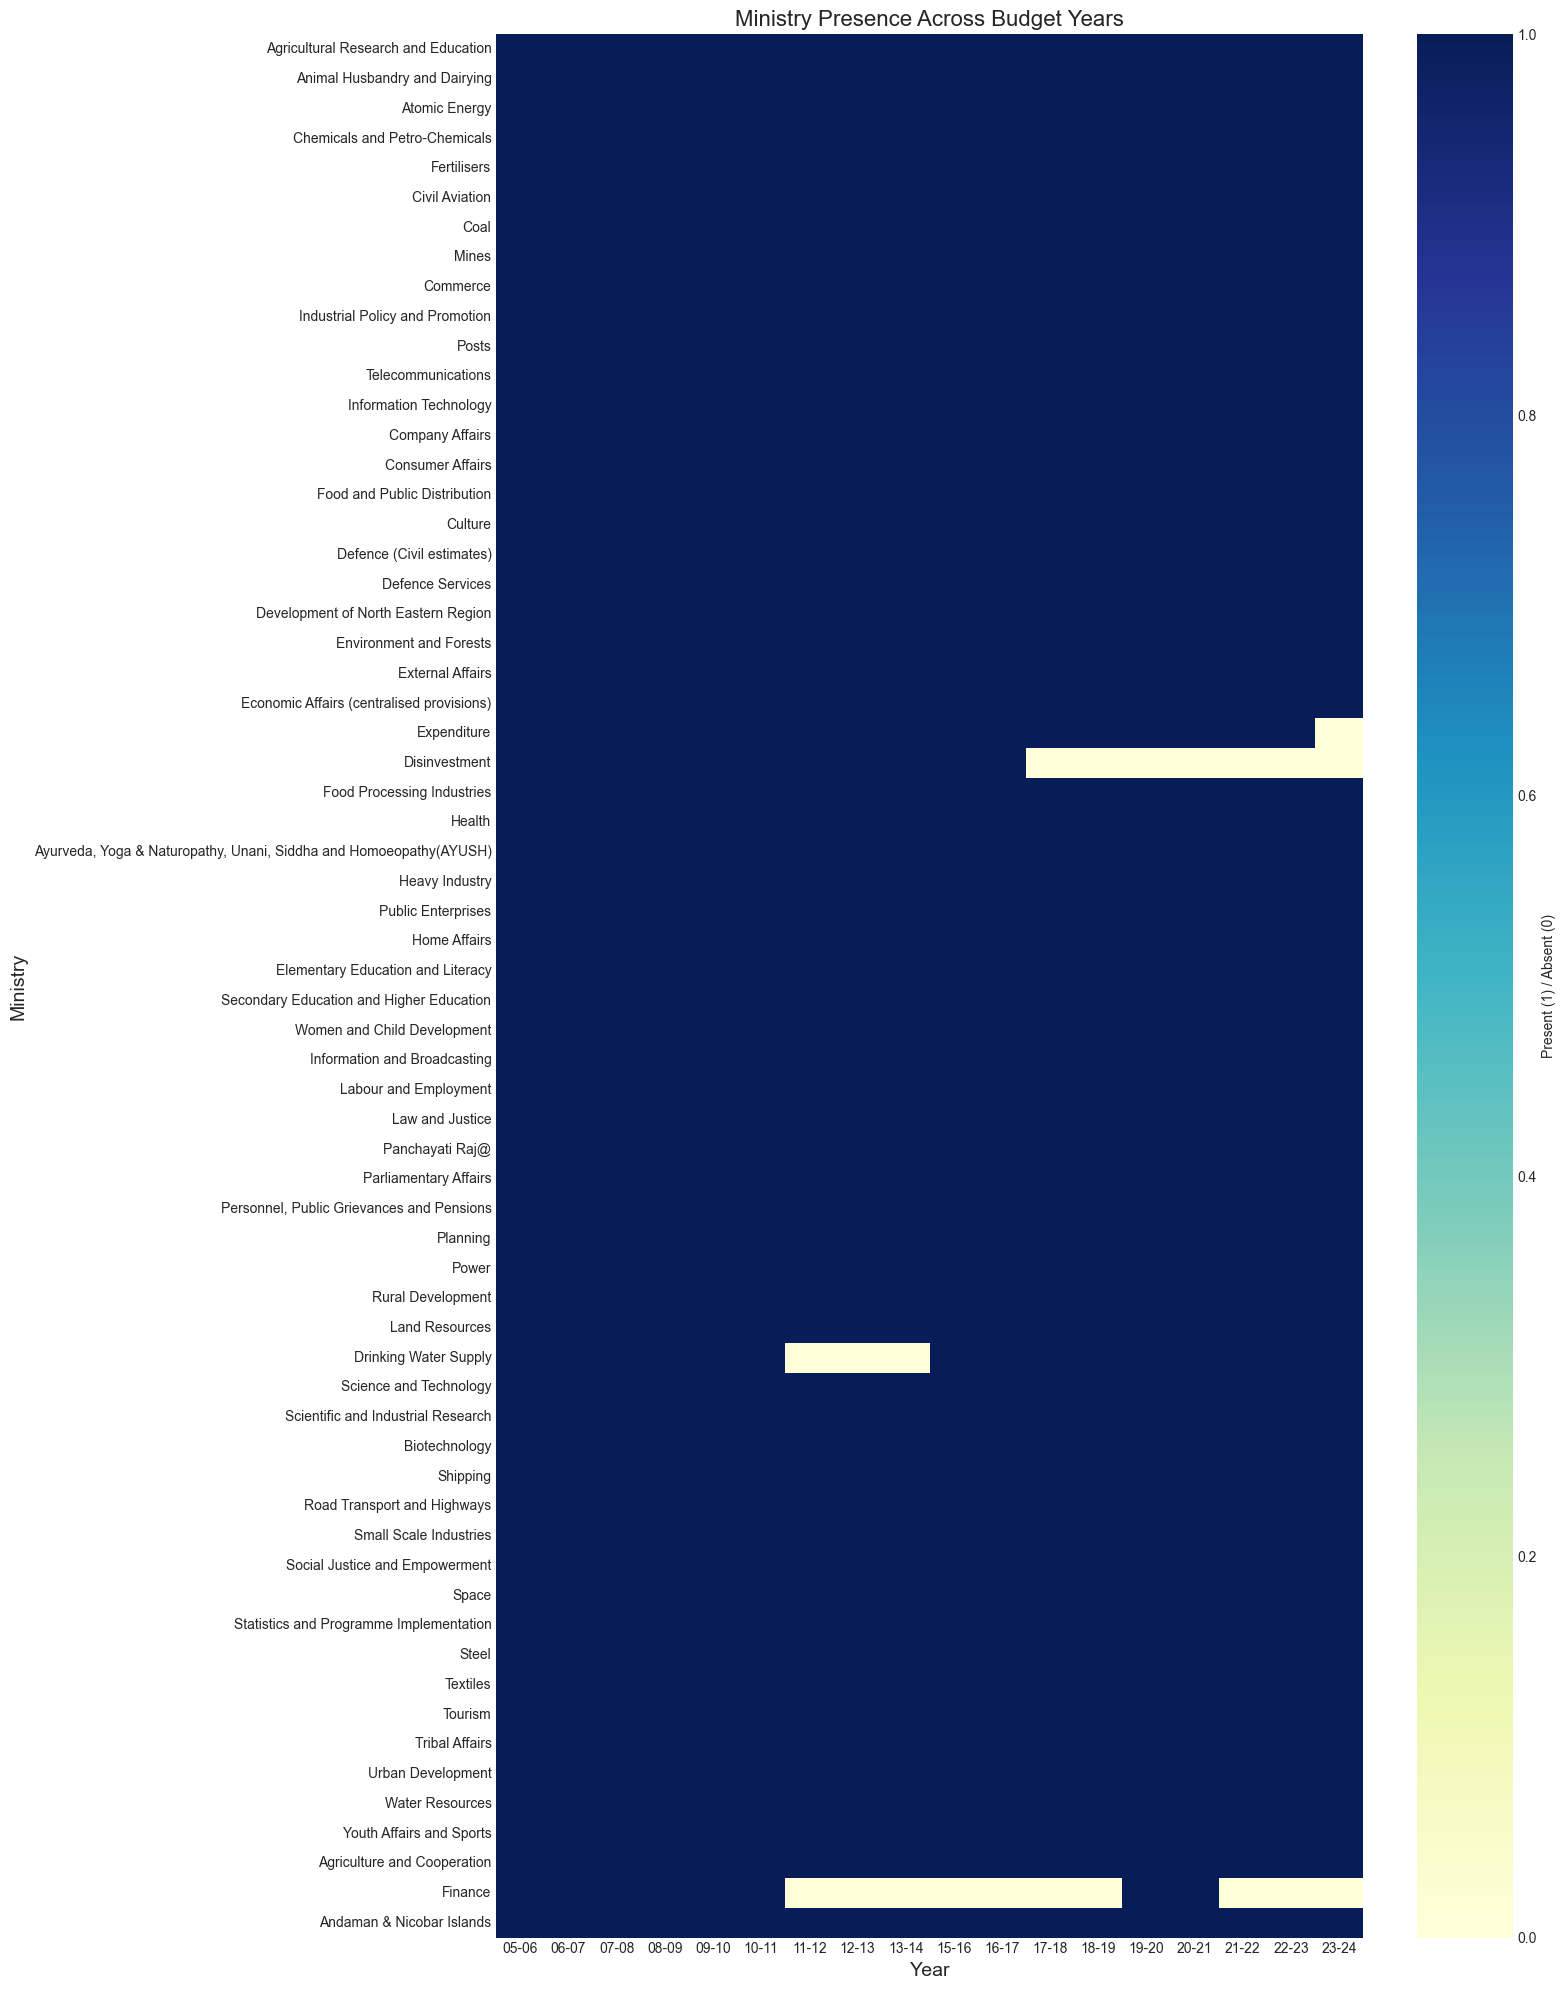


Ministries with lowest coverage across years:
Finance                                 44.444444
Disinvestment                           61.111111
Drinking Water Supply                   83.333333
Expenditure                             94.444444
Agricultural Research and Education    100.000000
Information and Broadcasting           100.000000
Labour and Employment                  100.000000
Law and Justice                        100.000000
Panchayati Raj@                        100.000000
Parliamentary Affairs                  100.000000
dtype: float64

Ministries with highest coverage across years:
Agricultural Research and Education          100.0
Biotechnology                                100.0
Women and Child Development                  100.0
Information and Broadcasting                 100.0
Labour and Employment                        100.0
Law and Justice                              100.0
Panchayati Raj@                              100.0
Parliamentary Affairs            

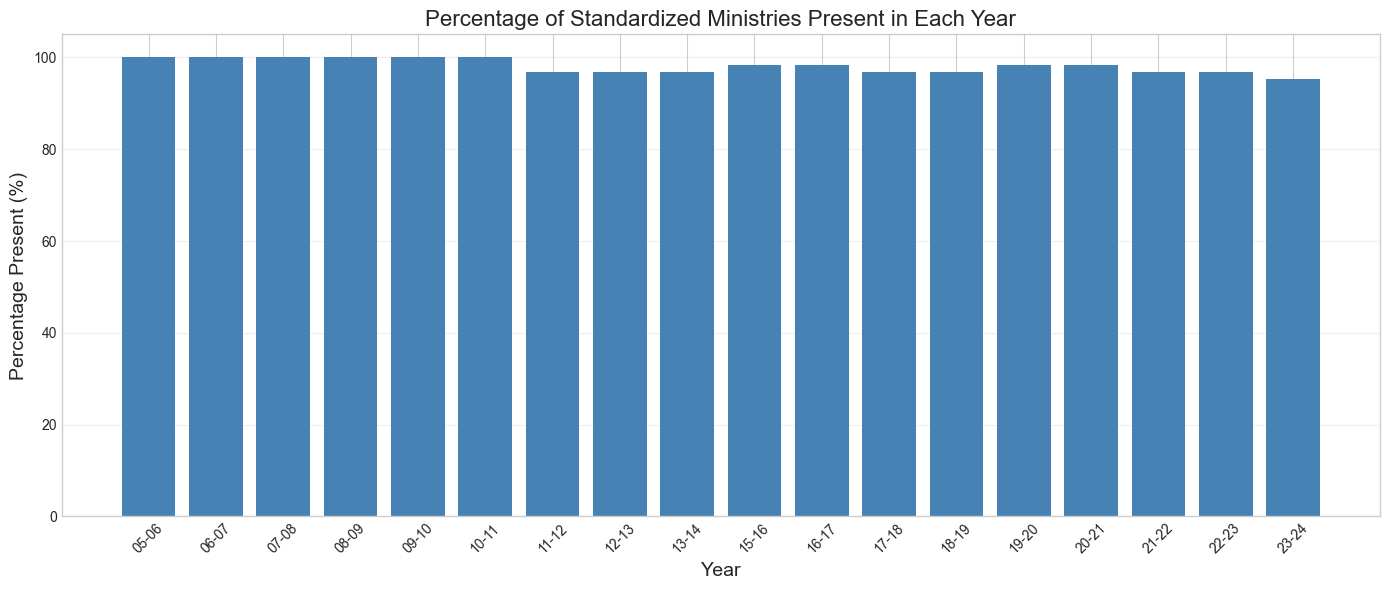


Ministries added since 05-06 (46):
- agriculture and farmers welfare
- ayush
- cabinet
- capital outlay on defence services
- central vigilance commission
- chemicals and petrochemicals
- cooperation
- corporate affairs
- defence pensions
- department for promotion of industry and internal trade
... and 36 more

Ministries removed since 05-06 (43):
- agriculture and cooperation
- agro and rural industries
- andaman and nicobar islands
- ayurveda, yoga and naturopathy, unani, siddha and homoeopathy
- central ministries/departments total
- central pool of resources for ne and sikkim
- chandigarh
- chemicals and petro-chemicals
- company affairs
- dadra and nagar haveli
... and 33 more

Analysis complete. Results saved to ministry_presence_analysis.csv

--- Checking ministry matching between standardized data and 23-24 budget ---
Found matches for 61 out of 64 ministries (95.3%)

Ministries in standardized data NOT found in 23-24 budget:
- Expenditure
- Disinvestment
- Finance
Ministry m

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

# 1. Load the standardized budget data
time_series_data = pd.read_csv('/Users/vvmohith/Desktop/PROJECT/final_data/standardized_budget_time_series.csv')

# Extract the list of unique ministries
ministries = time_series_data['Base_Ministry'].unique()
print(f"Found {len(ministries)} unique ministries in the standardized data")

# 2. Get the list of yearly budget files
dataset_path = '/Users/vvmohith/Desktop/PROJECT/dataset-final'
years = []
budget_files = {}

# Function to standardize ministry names for comparison
def standardize_ministry_name(name):
    if pd.isna(name):
        return ""
    
    # Remove numbering and spaces
    name = str(name).lower().strip()
    name = re.sub(r'^\d+\.\s*', '', name)  # Remove numbering at the beginning
    name = name.replace("ministry of ", "").replace("department of ", "")
    name = name.replace("&", "and")
    name = name.replace("'s", "").replace("'", "")
    
    # Remove content in parentheses
    name = re.sub(r'\(.*?\)', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    
    return name

# Function to find matches using fuzzy matching
def find_ministry_match(ministry, ministry_list, threshold=80):
    if len(ministry_list) == 0:
        return None, 0
    
    # Clean the ministry name
    std_ministry = standardize_ministry_name(ministry)
    
    # Find best match using fuzzy matching
    best_match, score = process.extractOne(std_ministry, ministry_list)
    
    if score >= threshold:
        return best_match, score
    else:
        return None, score

# Walk through the dataset directory and find CSV files
for year_folder in sorted(os.listdir(dataset_path)):
    if os.path.isdir(os.path.join(dataset_path, year_folder)) and re.match(r'^\d{2}-\d{2}$', year_folder):
        years.append(year_folder)
        
        # Look for CSV files in the year folder
        for file in os.listdir(os.path.join(dataset_path, year_folder)):
            if file.endswith('.csv') and not file.endswith('_with_share.csv'):
                budget_files[year_folder] = os.path.join(dataset_path, year_folder, file)
                break

print(f"Found budget files for {len(budget_files)} years: {', '.join(sorted(budget_files.keys()))}")

# 3. Create a DataFrame to track ministry presence in each year
# Initialize with zeros to ensure all values are numeric
presence_data = pd.DataFrame(0, index=ministries, columns=sorted(budget_files.keys()))

# Track all ministries found in yearly files
all_yearly_ministries = {}

# 4. Check each year's budget file for the presence of each ministry
for year, file_path in sorted(budget_files.items()):
    try:
        # Load the budget file
        yearly_budget = pd.read_csv(file_path)
        
        # Determine which column has the ministry names (usually the first column)
        ministry_col = yearly_budget.columns[0]
        
        # Extract ministry names and standardize them
        yearly_ministries = [standardize_ministry_name(m) for m in yearly_budget[ministry_col].dropna()]
        all_yearly_ministries[year] = yearly_ministries
        
        # Check each standardized ministry for a match
        for ministry in ministries:
            std_ministry = standardize_ministry_name(ministry)
            match, score = find_ministry_match(std_ministry, yearly_ministries)
            
            if match:
                presence_data.loc[ministry, year] = 1
            else:
                presence_data.loc[ministry, year] = 0
                
        print(f"Processed {year} budget file with {len(yearly_ministries)} ministries")
    except Exception as e:
        print(f"Error processing {year} budget file: {str(e)}")
        # Set to zero instead of NaN to maintain numeric type
        presence_data.loc[:, year] = 0

# Ensure all values are numeric
presence_data = presence_data.astype(float)

# 5. Create a heatmap visualization
plt.figure(figsize=(16, 20))
presence_heatmap = sns.heatmap(presence_data, cmap="YlGnBu", cbar_kws={'label': 'Present (1) / Absent (0)'})
plt.title('Ministry Presence Across Budget Years', fontsize=16)
plt.ylabel('Ministry', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.tight_layout()
plt.savefig('/Users/vvmohith/Desktop/PROJECT/ministry_presence_heatmap.png', dpi=300)
plt.show()

# 6. Calculate and display coverage statistics
ministry_coverage = presence_data.sum(axis=1) / len(budget_files) * 100
year_coverage = presence_data.sum(axis=0) / len(ministries) * 100

print("\nMinistries with lowest coverage across years:")
print(ministry_coverage.sort_values().head(10))

print("\nMinistries with highest coverage across years:")
print(ministry_coverage.sort_values(ascending=False).head(10))

print("\nYears with lowest ministry coverage:")
print(year_coverage.sort_values().head(5))

print("\nYears with highest ministry coverage:")
print(year_coverage.sort_values(ascending=False).head(5))

# 7. Calculate the percentage of ministries present in each year
year_percentages = presence_data.mean() * 100

# Create a bar chart
plt.figure(figsize=(14, 6))
plt.bar(year_percentages.index, year_percentages.values, color="steelblue")
plt.title('Percentage of Standardized Ministries Present in Each Year', fontsize=16)
plt.ylabel('Percentage Present (%)', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/Users/vvmohith/Desktop/PROJECT/ministry_coverage_by_year.png', dpi=300)
plt.show()

# 8. Calculate which ministries have been added or removed over time
first_year = sorted(budget_files.keys())[0]
last_year = sorted(budget_files.keys())[-1]

if first_year in all_yearly_ministries and last_year in all_yearly_ministries:
    early_ministries = set(all_yearly_ministries[first_year])
    recent_ministries = set(all_yearly_ministries[last_year])
    
    added = recent_ministries - early_ministries
    removed = early_ministries - recent_ministries
    
    print(f"\nMinistries added since {first_year} ({len(added)}):")
    for ministry in sorted(list(added))[:10]:  # Show top 10
        print(f"- {ministry}")
    if len(added) > 10:
        print(f"... and {len(added) - 10} more")
        
    print(f"\nMinistries removed since {first_year} ({len(removed)}):")
    for ministry in sorted(list(removed))[:10]:  # Show top 10
        print(f"- {ministry}")
    if len(removed) > 10:
        print(f"... and {len(removed) - 10} more")

# 9. Save the presence data to a CSV file for further analysis
presence_data.to_csv('/Users/vvmohith/Desktop/PROJECT/ministry_presence_analysis.csv')
print("\nAnalysis complete. Results saved to ministry_presence_analysis.csv")

# 10. Add a check to see which ministries in standardized_budget_time_series.csv match with those in 23-24.csv
try:
    print("\n--- Checking ministry matching between standardized data and 23-24 budget ---")
    # Load 23-24 data
    latest_data = pd.read_csv('/Users/vvmohith/Desktop/PROJECT/dataset-final/23-24/23-24.csv')
    
    # Get the ministries column (first column)
    ministry_col_latest = latest_data.columns[0]
    
    # Standardize the latest budget ministries
    latest_ministries = [standardize_ministry_name(m) for m in latest_data[ministry_col_latest].dropna()]
    
    # Check each standardized ministry for a match in the latest budget
    match_status = []
    for ministry in ministries:
        std_ministry = standardize_ministry_name(ministry)
        match, score = find_ministry_match(std_ministry, latest_ministries)
        
        match_status.append({
            'Standardized_Ministry': ministry,
            'Found_in_23_24': 'Yes' if match else 'No',
            'Match_Score': score if match else 0,
            'Matched_With': match if match else None
        })
    
    # Convert to DataFrame and display
    match_df = pd.DataFrame(match_status)
    
    # Count matches and non-matches
    match_count = match_df[match_df['Found_in_23_24'] == 'Yes'].shape[0]
    total = match_df.shape[0]
    
    print(f"Found matches for {match_count} out of {total} ministries ({match_count/total*100:.1f}%)")
    
    # Display ministries not found in latest budget
    not_found = match_df[match_df['Found_in_23_24'] == 'No']
    if not not_found.empty:
        print("\nMinistries in standardized data NOT found in 23-24 budget:")
        for _, row in not_found.iterrows():
            print(f"- {row['Standardized_Ministry']}")
    
    # Save the matching results
    match_df.to_csv('/Users/vvmohith/Desktop/PROJECT/ministry_matching_23_24.csv', index=False)
    print("Ministry matching results saved to ministry_matching_23_24.csv")
    
except Exception as e:
    print(f"Error during ministry matching check: {str(e)}")

Found 63 ministries in standardized budget data
Found 92 ministries in 23-24 budget data

Match Status Counts:
Status
Exact Match    52
Close Match    11
Name: count, dtype: int64

=== EXACT MATCHES (90%+ similarity) ===
                  Standardized_Ministry  \
0   Agricultural Research and Education   
31          Women and Child Development   
1         Animal Husbandry and Dairying   
34                      Law and Justice   
35                      Panchayati Raj@   
36                Parliamentary Affairs   
38                             Planning   
39                                Power   
40                    Rural Development   
41                       Land Resources   

                                         Latest_Match  Match_Score  
0   2.    Department of Agricultural Research and ...          100  
31    101.    Ministry of Women and Child Development          100  
1   44.    Department of Animal Husbandry and Dair...          100  
34                           

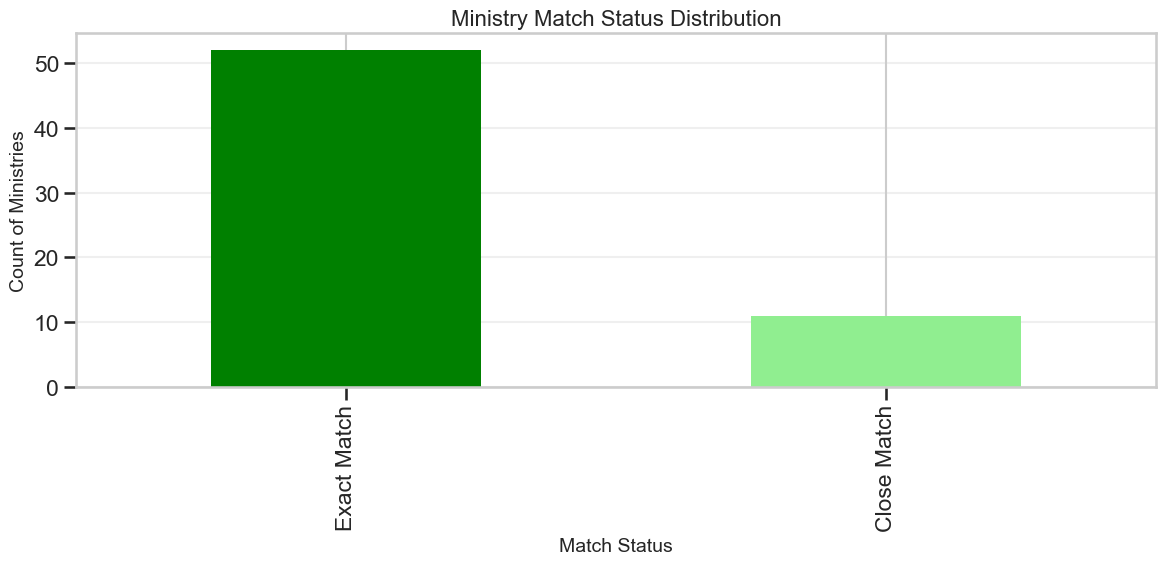

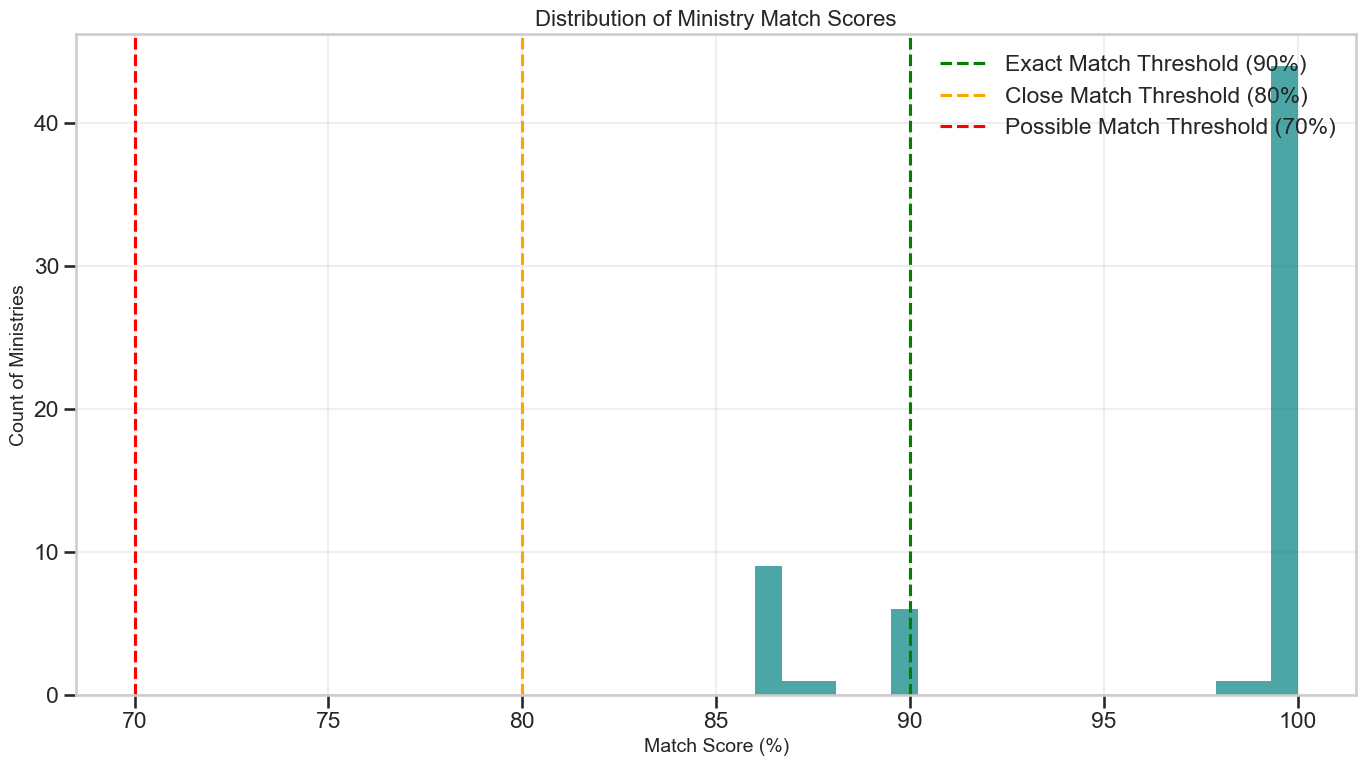


Analysis complete. Results saved to CSV files.


In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Set up display and plotting parameters
pd.set_option('display.max_rows', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
sns.set_context("talk")

# Load the datasets
standardized_data = pd.read_csv('/Users/vvmohith/Desktop/PROJECT/final_data/standardized_budget_time_series.csv')
latest_budget = pd.read_csv('/Users/vvmohith/Desktop/PROJECT/dataset-final/23-24/23-24.csv')

# Function to standardize ministry names for better comparison
def standardize_ministry_name(name):
    if pd.isna(name):
        return ""
    
    # Remove numbering and spaces
    name = str(name).lower().strip()
    name = re.sub(r'^\d+\.\s*', '', name)  # Remove numbering at the beginning
    name = name.replace("ministry of ", "").replace("department of ", "")
    name = name.replace("&", "and")
    name = name.replace("'s", "").replace("'", "")
    
    # Remove content in parentheses
    name = re.sub(r'\(.*?\)', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    
    return name

# Extract and standardize ministry lists
std_ministries = standardized_data['Base_Ministry'].tolist()
latest_ministries = latest_budget['MINISTRY/DEPARTMENT'].tolist()

# Create standardized versions for comparison
std_ministries_clean = [standardize_ministry_name(m) for m in std_ministries]
latest_ministries_clean = [standardize_ministry_name(m) for m in latest_ministries]

print(f"Found {len(std_ministries)} ministries in standardized budget data")
print(f"Found {len(latest_ministries)} ministries in 23-24 budget data")

# Create a detailed matching result
matching_results = []

# Compare each standardized ministry with latest budget data
for i, ministry in enumerate(std_ministries):
    std_clean = std_ministries_clean[i]
    best_match, score = process.extractOne(std_clean, latest_ministries_clean)
    
    # Find the original name of the best match
    match_index = latest_ministries_clean.index(best_match)
    original_match = latest_ministries[match_index]
    
    # Determine match status
    if score >= 90:
        status = "Exact Match"
    elif score >= 80:
        status = "Close Match"
    elif score >= 70:
        status = "Possible Match"
    else:
        status = "No Match"
    
    # Get budget values
    std_budget = None
    if '23-24' in standardized_data.columns:
        std_budget = standardized_data.loc[standardized_data['Base_Ministry'] == ministry, '23-24'].values[0]
    
    latest_budget_value = None
    if match_index < len(latest_budget):
        latest_budget_value = latest_budget.iloc[match_index]['Total']
    
    matching_results.append({
        'Standardized_Ministry': ministry,
        'Standardized_Clean': std_clean,
        'Latest_Match': original_match,
        'Latest_Clean': best_match,
        'Match_Score': score,
        'Status': status,
        'Standardized_Budget': std_budget,
        'Latest_Budget': latest_budget_value
    })

# Convert to DataFrame for analysis
match_df = pd.DataFrame(matching_results)

# Now check the reverse - ministries in 23-24 that don't match well with any in standardized data
reverse_matches = []

for i, ministry in enumerate(latest_ministries):
    latest_clean = latest_ministries_clean[i]
    best_match, score = process.extractOne(latest_clean, std_ministries_clean)
    
    # Only add if it's a poor match
    if score < 80:
        match_index = std_ministries_clean.index(best_match)
        original_match = std_ministries[match_index]
        
        reverse_matches.append({
            'Latest_Ministry': ministry,
            'Latest_Clean': latest_clean,
            'Best_Std_Match': original_match,
            'Best_Std_Clean': best_match,
            'Match_Score': score
        })

reverse_df = pd.DataFrame(reverse_matches)

# Analyze match results
match_counts = match_df['Status'].value_counts()
print("\nMatch Status Counts:")
print(match_counts)

# Display matches by category
print("\n=== EXACT MATCHES (90%+ similarity) ===")
exact_matches = match_df[match_df['Status'] == 'Exact Match'].sort_values('Match_Score', ascending=False)
print(exact_matches[['Standardized_Ministry', 'Latest_Match', 'Match_Score']].head(10))

print("\n=== CLOSE MATCHES (80-90% similarity) ===")
close_matches = match_df[match_df['Status'] == 'Close Match'].sort_values('Match_Score', ascending=False)
print(close_matches[['Standardized_Ministry', 'Latest_Match', 'Match_Score']].head(10))

print("\n=== POSSIBLE MATCHES (70-80% similarity) ===")
possible_matches = match_df[match_df['Status'] == 'Possible Match'].sort_values('Match_Score', ascending=False)
print(possible_matches[['Standardized_Ministry', 'Latest_Match', 'Match_Score']].head(10))

print("\n=== NO MATCHES (< 70% similarity) ===")
no_matches = match_df[match_df['Status'] == 'No Match'].sort_values('Match_Score', ascending=False)
print(no_matches[['Standardized_Ministry', 'Latest_Match', 'Match_Score']].head(10))

print("\n=== MINISTRIES IN 23-24 WITH NO GOOD MATCH IN STANDARDIZED DATA ===")
print(reverse_df[['Latest_Ministry', 'Best_Std_Match', 'Match_Score']].head(10))

# Create visualization of match statistics
plt.figure(figsize=(12, 6))
match_counts.plot(kind='bar', color=['green', 'lightgreen', 'orange', 'red'])
plt.title('Ministry Match Status Distribution', fontsize=16)
plt.xlabel('Match Status', fontsize=14)
plt.ylabel('Count of Ministries', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('/Users/vvmohith/Desktop/PROJECT/ministry_match_distribution.png', dpi=300)
plt.show()

# Create visual of match scores
plt.figure(figsize=(14, 8))
plt.hist(match_df['Match_Score'], bins=20, color='teal', alpha=0.7)
plt.axvline(x=90, color='green', linestyle='--', label='Exact Match Threshold (90%)')
plt.axvline(x=80, color='orange', linestyle='--', label='Close Match Threshold (80%)')
plt.axvline(x=70, color='red', linestyle='--', label='Possible Match Threshold (70%)')
plt.title('Distribution of Ministry Match Scores', fontsize=16)
plt.xlabel('Match Score (%)', fontsize=14)
plt.ylabel('Count of Ministries', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('/Users/vvmohith/Desktop/PROJECT/ministry_match_scores.png', dpi=300)
plt.show()

# Create a manual mapping for future reference
# This will help with building a reference table for ministry name changes
mapping_reference = match_df.copy()
mapping_reference['Suggested_Action'] = 'No Action'
mapping_reference.loc[mapping_reference['Status'] == 'Exact Match', 'Suggested_Action'] = 'Direct Map'
mapping_reference.loc[mapping_reference['Status'] == 'Close Match', 'Suggested_Action'] = 'Review & Map'
mapping_reference.loc[mapping_reference['Status'] == 'Possible Match', 'Suggested_Action'] = 'Manual Review'
mapping_reference.loc[mapping_reference['Status'] == 'No Match', 'Suggested_Action'] = 'Create New Mapping'

# Save detailed results for further analysis
match_df.to_csv('/Users/vvmohith/Desktop/PROJECT/ministry_match_analysis.csv', index=False)
reverse_df.to_csv('/Users/vvmohith/Desktop/PROJECT/missing_from_standardized.csv', index=False)
mapping_reference.to_csv('/Users/vvmohith/Desktop/PROJECT/ministry_mapping_reference.csv', index=False)

print("\nAnalysis complete. Results saved to CSV files.")